In [7]:
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.utils import compute_class_weight
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
import itertools
from sklearn.metrics import classification_report

In [8]:
df = pd.read_csv('Training_Dataset/2500_training_data_2.csv')
X,y = df['tweet'],df['label']
print X.shape, y.shape

(2513,) (2513,)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 45)
# print X_train.shape
# print X_train

# Feature Extraction (TF-IDF) unigrams and bigrams

In [10]:
#   - Filters out terms that occur in only one document (min_df=2).
vectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1,2),min_df=2)
X = vectorizer.fit_transform(X_train) 
train_tfidf_feature = X.toarray()
print train_tfidf_feature
# print train_tfidf_feature.shape

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


# Feature Extraction (LSA)
Latent Semantic Analysis is a technique that analyzes relationship between a set of documents and of the terms. This method will extract contextual-usage meaning of words by statistical computations applied to a large corpus of text. 

Input: X[m][n] -> a matrix where m is the number of documents and n is the number of terms. 

The matrix X will be decomposed into three matrices called the U, S, and T. In doing the decomposition, a value of <i>k</i> will have to be picked since it will represent the number of concepts kept. 

<center>$X\approx USV^{T} $</center>

U[m][k] where the rows are the documents and the columns will be the mathematical concepts.

S[k][k] is a diagonal matrix where elements will be the amount of variation captured from each concept. 

V[m][k] transpose where the rows will be terms and the columns will be concepts.

In [11]:
lsa = TruncatedSVD(n_components = 300, n_iter=500)
train_lsa_feature = lsa.fit_transform(X)
print train_lsa_feature.shape

(2010, 300)


In [12]:
# #### To view list of related concepts
# terms = vectorizer.get_feature_names()
# for i, comp in enumerate(train_lsa_feature):
#     termsInComp = zip (terms, comp)
#     sortedTerms = sorted(termsInComp, key=lambda x: x[1], reverse = True) [:10]
#     print "Concept %d:" % i
#     for term in sortedTerms:
#         print term[0]
#     print " "

# SVM Classifier

# Concatenating features

In [13]:
train_final_representation = np.concatenate((train_tfidf_feature,train_lsa_feature),axis=1)

In [14]:
class_weights = compute_class_weight('balanced', [0, 1], y)
class_weight_dictionary = {1:class_weights[0], 1:class_weights[1]}
clf3 = SGDClassifier(class_weight=class_weight_dictionary,loss="hinge",
                    penalty="l2", shuffle=True,)
# clf3 = SGDClassifier(class_weight=class_weight_dictionary)
clf3.partial_fit(train_final_representation,y_train,classes=[0,1])

SGDClassifier(alpha=0.0001, average=False,
       class_weight={1: 1.3945615982241952}, epsilon=0.1, eta0=0.0,
       fit_intercept=True, l1_ratio=0.15, learning_rate='optimal',
       loss='hinge', n_iter=5, n_jobs=1, penalty='l2', power_t=0.5,
       random_state=None, shuffle=True, verbose=0, warm_start=False)

# Testing Classifier

In [15]:
X2 = vectorizer.transform(X_test)
test_tfidf_feature = X2.toarray()
test_lsa_feature = lsa.transform(X2)

In [16]:
test_final_representation = np.concatenate((test_tfidf_feature,test_lsa_feature),axis=1)
accuracy3 = clf3.score(test_final_representation,y_test) *100
prediction3 = clf3.predict(test_final_representation)
print "Accuracy: ",accuracy3
# print "Prediction: ",prediction3

Accuracy:  73.3598409543


In [17]:
print test_final_representation

[[ 0.          0.          0.         ..., -0.04351316  0.02080192
  -0.02307412]
 [ 0.          0.          0.         ..., -0.01641417 -0.01683595
  -0.02060414]
 [ 0.          0.          0.         ..., -0.01462414 -0.02379846
  -0.05929142]
 ..., 
 [ 0.          0.          0.         ...,  0.00924419 -0.00893133
  -0.0389082 ]
 [ 0.          0.          0.         ..., -0.06245878  0.01927442
  -0.02430467]
 [ 0.          0.          0.         ...,  0.05975423  0.00376039
  -0.09790746]]


In [18]:
cf3 = confusion_matrix(y_test,prediction3)
print "CONCATENATED: "
print cf3


CONCATENATED: 
[[244  79]
 [ 55 125]]


Confusion matrix, without normalization
[[244  79]
 [ 55 125]]
Normalized confusion matrix
[[ 0.76  0.24]
 [ 0.31  0.69]]


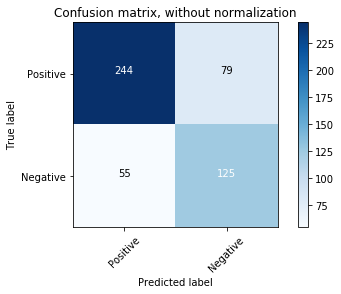

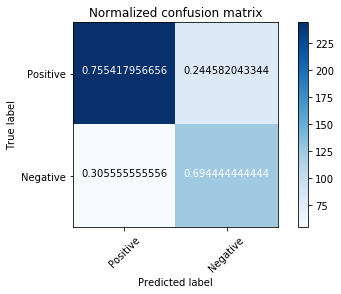

In [20]:
class_names = ['Positive', 'Negative']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, prediction3)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [21]:
print "Classification Report: "
print(classification_report(y_test, prediction3))

Classification Report: 
             precision    recall  f1-score   support

          0       0.82      0.76      0.78       323
          1       0.61      0.69      0.65       180

avg / total       0.74      0.73      0.74       503



In [22]:
# save to pickle
import pickle

with open('Models/classifier.pkl', 'wb') as f:
    pickle.dump(clf3, f)
    
with open('Models/vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)
    
with open('Models/lsa.pkl', 'wb') as f:
    pickle.dump(lsa, f)
